In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

from plot import create_stacked_plot
from utils import calculate_comp_and_comm_time
sns.set_theme()

In [32]:
import re

def create_combined_comm_overhead_df(logs_dir: Path, pattern: str) -> pd.DataFrame: 
  """Create a combined DataFrame using all the files in a folder matching a 
  given RegEx. Note that the pattern has to have three capturing groups, where 
  the first one is the strategy, the second one the number of GPUs and the 
  third one the global rank of the worker. 
  """
  pattern = re.compile(pattern)
  dataframes = []
  for entry in logs_dir.iterdir(): 
    match = pattern.search(str(entry))
    if not match: 
      continue
    
    # Getting the captured regex groups, i.e. the contents of "(\d+)"
    strategy, num_gpus, global_rank = match.groups()
    df = pd.read_csv(entry)
    df["num_gpus"] = num_gpus
    df["global_rank"] = global_rank
    df["strategy"] = strategy
    
    dataframes.append(df)
    
  df = pd.concat(dataframes)
  return df

logs_dir = Path("logs")
pattern = f"profile_(\w+)_(\d+)_(\d+)\.csv$"
df = create_combined_comm_overhead_df(logs_dir=logs_dir, pattern=pattern)

# df = pd.concat(dataframes)
print(len(df))
df.head(5)

7420


,name,node_id,self_cpu_time_total,cpu_time_total,cpu_time_total_str,self_cuda_time_total,cuda_time_total,cuda_time_total_str,calls,num_gpus,global_rank,strategy
0,record_param_comms,-1,1461322,2958723,2.959s,308395,1024729,1.025s,936,8,2,deepspeed
1,aten::to,-1,4710,921078,921.078ms,0,641451,641.451ms,1886,8,2,deepspeed
2,aten::_to_copy,-1,3471,920195,920.195ms,0,647386,647.386ms,944,8,2,deepspeed
3,aten::empty_strided,-1,8191,211755,211.755ms,0,16999,16.999ms,1417,8,2,deepspeed
4,cudaDeviceGetStreamPriorityRange,-1,97,97,97.000us,31507,31507,31.507ms,4645,8,2,deepspeed


In [33]:
def get_comp_fraction_full_array(df: pd.DataFrame) -> np.ndarray: 
  unique_num_gpus = sorted(df["num_gpus"].unique(), key=lambda x: int(x))
  unique_strategies = df["strategy"].unique()
  values = []

  for strategy in unique_strategies: 
    strategy_values = []
    for num_gpus in unique_num_gpus: 
      filtered_df = df[(df["strategy"] == strategy) & (df["num_gpus"] == num_gpus)]
      
      # For now we assume that we test all strategies for all sizes, but this might 
      # be useful to change later
      assert len(filtered_df) > 0
      comp_time, comm_time = calculate_comp_and_comm_time(df=filtered_df)
      comp_fraction = comp_time / (comp_time + comm_time)
      strategy_values.append(comp_fraction)
      
      print(f"Strategy: {strategy:>10}, Num GPUs: {num_gpus}, comp_time: {comp_time:.2f}, comm_time: {comm_time:.2f}")
    values.append(strategy_values)

  return np.array(values)

# strategies = df["strategy"].unique()
# gpu_numbers = sorted(df["num_gpus"].unique(), key=lambda x: int(x))
# print(f"Strategies: {strategies}, GPU Numbers: {gpu_numbers}")

values = get_comp_fraction_full_array(df)
print(f"Values: {values}")

Strategies: ['deepspeed' 'ddp' 'horovod'], GPU Numbers: ['4', '8']
Strategy:  deepspeed, Num GPUs: 4, comp_time: 42.20, comm_time: 0.54
Strategy:  deepspeed, Num GPUs: 8, comp_time: 42.31, comm_time: 2.42
Strategy:        ddp, Num GPUs: 4, comp_time: 14.85, comm_time: 22.13
Strategy:        ddp, Num GPUs: 8, comp_time: 42.61, comm_time: 76.41
Strategy:    horovod, Num GPUs: 4, comp_time: 41.96, comm_time: 16.66
Strategy:    horovod, Num GPUs: 8, comp_time: 41.14, comm_time: 22.51
Values: [[0.98731852 0.94592376]
 [0.40153633 0.35800593]
 [0.71584043 0.64630768]]


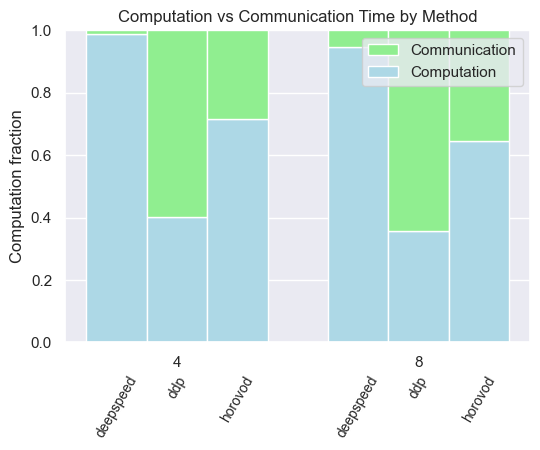

In [34]:
fig, ax = create_stacked_plot(values, strategies, gpu_numbers)
fig.set_figwidth(6)
fig.set_figheight(4)

plt.show()